In [1]:
import ROOT
import pandas
import math
#matplotlib.use('agg')
%matplotlib inline
import matplotlib #as matplot
print(matplotlib.__version__)
#print(matplotlib.path)
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import time

from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
print(sk.__version__)
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
######################
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU 
from keras.optimizers import Adamax
from keras.optimizers import Nadam
print(kr.__version__)
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
config = tf.ConfigProto(intra_op_parallelism_threads=32, \
                        inter_op_parallelism_threads=32, \
                        allow_soft_placement=True, \
                        device_count = {'CPU': 32}
                       )
session = tf.Session(config=config)
K.set_session(session)

Welcome to JupyROOT 6.12/07
2.2.3
0.20.1
1.6.0
2.1.4
1.6.0


Using TensorFlow backend.


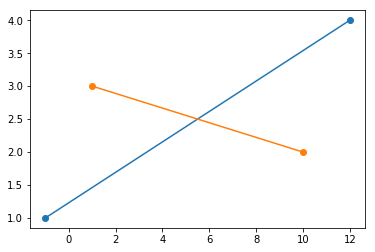

In [2]:
# test that matplotlib imported ok
x1, y1 = [-1, 12], [1, 4]
x2, y2 = [1, 10], [3, 2]
plt.plot(x1, y1, x2, y2, marker = 'o')
plt.show()

In [3]:
################
## load the data
################
channel='2l_2tau_HH'
bdtType = "evtLevelSUM_HH_2l_2tau_res"
tauID = "dR03mvaLoose"
%run ../python/data_manager.py
if channel=='2l_2tau_HH' : 
    %run ../cards/info_2l_2tau_HH.py
output = read_from(
    "default", 
    tauID
)

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-root_numpy/4.7.3-ikaegh4/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.2 is currently installed but you installed root_numpy against numpy 1.15.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


<Figure size 432x288 with 0 Axes>

In [4]:
print ("read from:", output["inputPath"])
print ("Date: ", time.asctime( time.localtime(time.time()) ))
data=load_data_2017(
    output["inputPath"], 
    output["channelInTree"], 
    trainVars(True), 
    [], 
    bdtType, 
    channel,
    output["keys"], 
    output["masses"]
) # note: I had to add channel as argument of the function
print (len(data))
print ("Date: ", time.asctime( time.localtime(time.time()) ))

('read from:', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/')
('Date: ', 'Tue Apr 16 13:18:51 2019')
bdttype=  evtLevelSUM_HH_2l_2tau_res
(folderName, channelTree) =  ('TTTo2L2Nu', 'hh_2l_2tau_sumOS_forBDTtraining')
TTTo2L2Nu size of sig, bkg, evtweight, tot weight of data:  0 1334 51.37169 51.37169
TTTo2L2Nu events with -ve weights 24
(folderName, channelTree) =  ('TTToSemiLeptonic', 'hh_2l_2tau_sumOS_forBDTtraining')
TTToSemiLeptonic size of sig, bkg, evtweight, tot weight of data:  0 24 0.2678624 0.2678624
TTToSemiLeptonic events with -ve weights 1
(folderName, channelTree) =  ('DY', 'hh_2l_2tau_sumOS_forBDTtraining')
DY size of sig, bkg, evtweight, tot weight of data:  0 199 40.94134 40.94134
DY events with -ve weights 6
(folderName, channelTree) =  ('ZZ', 'hh_2l_2tau_sumOS_forBDTtraining')
ZZ size of sig, bkg, evtweight, tot weight of data:  0 21228 8.200263 8.200263
ZZ events with -ve weights 3

In [9]:
weights="evtWeight"

print ("Date: ", time.asctime( time.localtime(time.time()) ))
data["weight_cx"] = data[weights]
data["weight_train"] = data[weights]
data["NN_output"] = 1.0

data_even = data.loc[(data["event"].values % 2 == 0) ]
data_odd = data.loc[~(data["event"].values % 2 == 0) ]

order_train = [data_odd, data_even]
order_train_name = ["odd","even"]


print ("balance datasets by even/odd chunck")
for data_do in order_train :
    #### Normalization by cross section
    for wei in ["weight_cx", "weight_train"] :
        data_do.loc[(data_do['key'].isin(['WZ'])), [wei]]                           *= output["WZdatacard"]/data_do.loc[(data_do['key'].isin(['WZ'])), weights].sum()
        data_do.loc[(data_do['key'].isin(['ZZ'])), [wei]]                           *= output["ZZdatacard"]/data_do.loc[(data_do['key'].isin(['ZZ'])), weights].sum()
        data_do.loc[(data_do['key'].isin(['DY'])), [wei]]                           *= output["DYdatacard"]/data_do.loc[(data_do['key'].isin(['DY'])), weights].sum()
        data_do.loc[(data_do['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic', 'TTToHadronic'])), [wei]] *= output["TTdatacard"]/data_do.loc[(data['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic', 'TTToHadronic'])), weights].sum()

    ### Normalize sig/BKG and do table of nevents/mass
    for mass in output["masses"] :
        data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"] *= 1000./data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"]== mass), "weight_train"].sum()
        data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"] *= 1000./data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"]== mass), "weight_train"].sum()
    print ("Date: ", time.asctime( time.localtime(time.time()) ))

    print ("training statistics by mass")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(len(data_do.loc[(data['target']==1) & (data_do["gen_mHH"] == mass),["weight_train"]]))+\
               " BKG = "+str(len(data_do.loc[(data['target']==0) & (data_do["gen_mHH"] == mass),["weight_train"]]))
              )

    print ("\n norm by mass - test")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"].sum())+\
               " BKG = "+str(data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"].sum())
              )

('Date: ', 'Tue Apr 16 13:21:21 2019')
balance datasets by even/odd chunck
('Date: ', 'Tue Apr 16 13:21:25 2019')
training statistics by mass
250: sig = 788 BKG = 642
260: sig = 763 BKG = 687
270: sig = 688 BKG = 650
280: sig = 750 BKG = 674
300: sig = 600 BKG = 664
350: sig = 713 BKG = 637
400: sig = 2128 BKG = 673
450: sig = 1105 BKG = 623
500: sig = 897 BKG = 677
550: sig = 1016 BKG = 684
600: sig = 1127 BKG = 647
650: sig = 1309 BKG = 678
700: sig = 3554 BKG = 661
750: sig = 1544 BKG = 640
800: sig = 1628 BKG = 721
850: sig = 1643 BKG = 649
900: sig = 911 BKG = 676
1000: sig = 1023 BKG = 646

 norm by mass - test
250: sig = 1000.0 BKG = 1000.0
260: sig = 1000.0 BKG = 1000.00006
270: sig = 999.99994 BKG = 1000.00006
280: sig = 1000.00006 BKG = 1000.00006
300: sig = 999.9999 BKG = 1000.0001
350: sig = 1000.0 BKG = 1000.0
400: sig = 1000.0 BKG = 1000.0
450: sig = 1000.0001 BKG = 1000.00006
500: sig = 1000.0 BKG = 999.99994
550: sig = 1000.0 BKG = 999.99994
600: sig = 1000.0 BKG = 1000

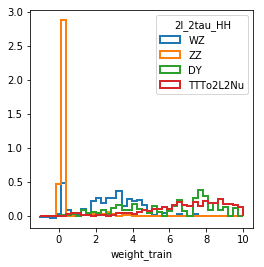

In [183]:
"""
Check of the resulting weights - the sizes of the training weight
"""
fig, ax = plt.subplots(figsize=(4, 4))
keysToBKG = ['WZ', 'ZZ', 'DY',  'TTTo2L2Nu'] # 'VH', 'ttH', 'TTZJets',  
#colors = ['cyan','orange','k','r','green','magenta','b',]
vars = ["weight_train"]#"multitarget"]

for kk, key in enumerate(keysToBKG) :
  for vv, var in enumerate(vars) : 
    ax.hist(
        np.array(data.loc[(data['key']==key), var].values,dtype='float64'), # 
        weights=data.loc[(data['key']==key), "evtWeight"], # "weight_train_cat"
        range=(-1.0,10.),bins=40, histtype='step', normed=True, lw=2, 
        label=key
    )
    ax.set_xlabel(var)
ax.legend(loc="best", title= channel)

In [13]:
## load the variables
trainvar = trainVars(False, "noTopness")
print trainvar

['mT_lep1', 'mT_lep2', 'tau1_pt', 'tau2_pt', 'met', 'm_ll', 'mTauTau', 'diHiggsVisMass', 'diHiggsMass', 'nBJet_medium', 'nElectron', 'max_tau_eta', 'max_lep_eta', 'sum_lep_charge', 'gen_mHH']


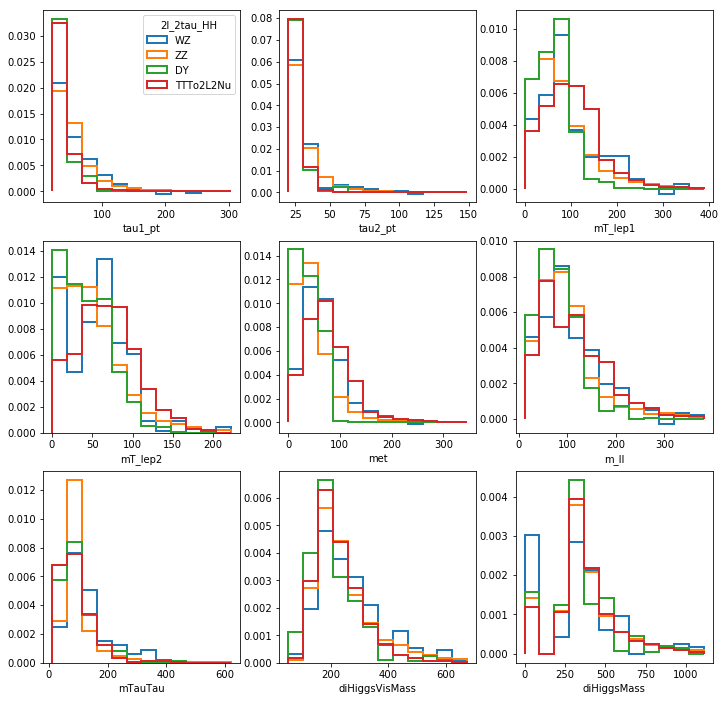

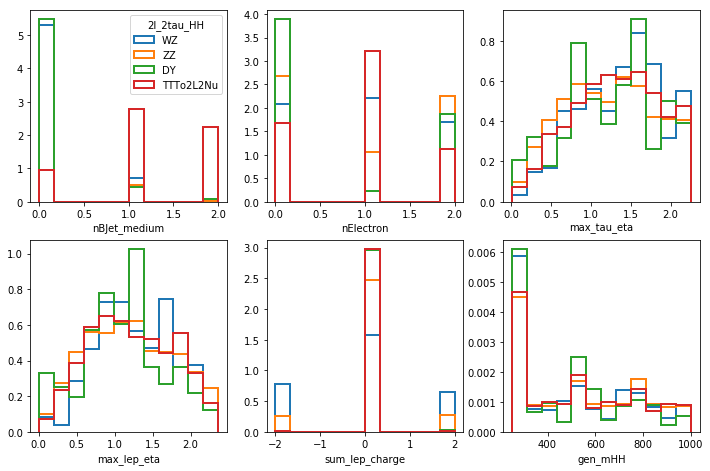

In [184]:
"""
Draw some plots on lists of variables for BKG
"""
#keysToBKG = ['TTZJets', 'WZ', 'ZZ', 'DY', 'VH', 'ttH', 'TTTo2L2Nu']
 
## i try to do 3 X 3 plots (= enter up to nine entries in each sublist)
## try to add strictly decreasing variables as first in each sublist, better for the legend positioning
listdraw = [
    [ 'tau1_pt', 'tau2_pt', 'mT_lep1', 'mT_lep2', 'met', 'm_ll', 'mTauTau', 'diHiggsVisMass', 'diHiggsMass' ], 
    ['nBJet_medium', 'nElectron', 'max_tau_eta', 'max_lep_eta', 'sum_lep_charge', 'gen_mHH'],
]
  
for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for kk, key in enumerate(keysToBKG) :
            if 'TTZJets' in key or 'TTWJets' in key : linestyle = "--"
            else :linestyle = "-"
            plt.hist(
            np.array(data.loc[(data['key']==key), feature].values,dtype='float64'), 
            weights=data.loc[(data['key']==key) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=12, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label=key
            )
            plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

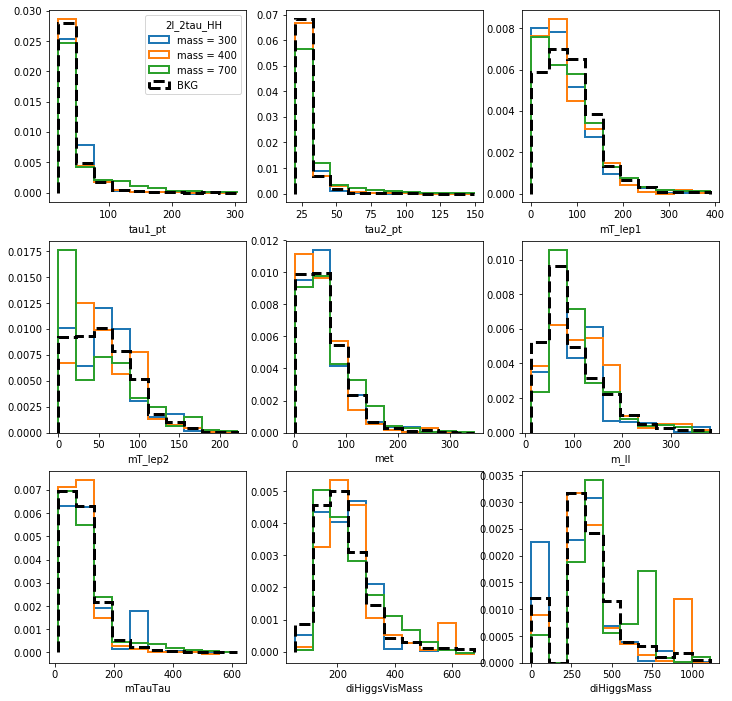

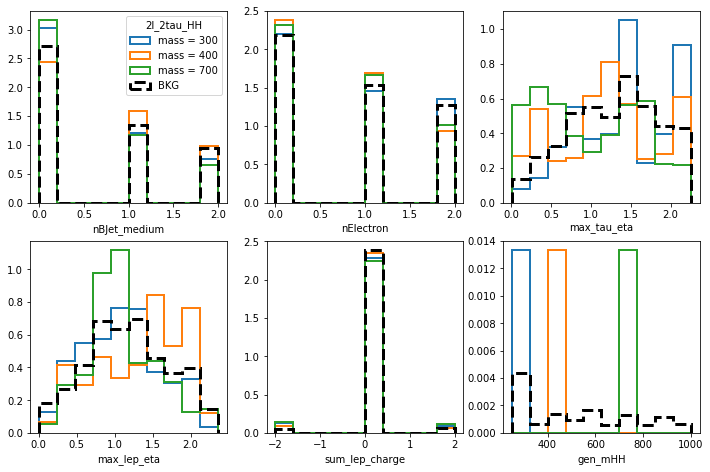

In [201]:
for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for mass in [300,400,700] :
            plt.hist(
            np.array(data.loc[(data["gen_mHH"] == mass), feature].values,dtype='float64'), 
            weights=data.loc[(data["gen_mHH"] == mass) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=10, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label="mass = "+str(mass)
            )
        plt.hist(
        np.array(data.loc[(data['target']==0), feature].values,dtype='float64'), 
        weights=data.loc[(data['target']==0) , "evtWeight"], 
        range=(min_value, max_value), 
        bins=10, histtype='step', ls='--', 
        normed=True, lw=3, color='k',
        label="BKG"
        )
        plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

In [105]:
# create model -- for binary activation='sigmoid'
nclasses = 1

def nn_model_binary():
    "create a model."
    model = Sequential()
    model.add(Dense(2*len(features), input_dim=len(features), kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(0.1))
    for Nnodes in [8,8] :
        model.add(Dense(Nnodes, kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        model.add(Dropout(0.1))
    model.add(Dense(nclasses, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(lr=0.0005, schedule_decay=0.00005), # , beta_1 = 0.95, beta_2 = 0.999
    metrics=['accuracy'], 
    )
    return model

In [86]:
nn_model_binary().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 30)                480       
_________________________________________________________________
batch_normalization_77 (Batc (None, 30)                120       
_________________________________________________________________
p_re_lu_77 (PReLU)           (None, 30)                30        
_________________________________________________________________
dropout_77 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 8)                 248       
_________________________________________________________________
batch_normalization_78 (Batc (None, 8)                 32        
_________________________________________________________________
p_re_lu_78 (PReLU)           (None, 8)                 8         
__________

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

In [106]:
features = trainvar
# Port Keras Framework into SK-Learn
# https://stackoverflow.com/questions/39467496/error-when-using-keras-sk-learn-api
k_model_binary  = KerasClassifier(
    build_fn=nn_model_binary, 
    epochs=10, 
    batch_size=64, 
    verbose=2
)

history = k_model_binary.fit(
    data_odd[features].values, 
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values,
    validation_data=(
        data_even[features].values, 
        data_even['target'].values, 
        data_even["weight_train"].values
    )
)

Train on 34116 samples, validate on 34015 samples
Epoch 1/10
 - 11s - loss: 0.7365 - acc: 0.4678 - val_loss: 0.5995 - val_acc: 0.6474
Epoch 2/10
 - 4s - loss: 0.5546 - acc: 0.7071 - val_loss: 0.4866 - val_acc: 0.8542
Epoch 3/10
 - 4s - loss: 0.4675 - acc: 0.8047 - val_loss: 0.4180 - val_acc: 0.8678
Epoch 4/10
 - 4s - loss: 0.4226 - acc: 0.8251 - val_loss: 0.3900 - val_acc: 0.8699
Epoch 5/10
 - 4s - loss: 0.3907 - acc: 0.8308 - val_loss: 0.3544 - val_acc: 0.8747
Epoch 6/10
 - 4s - loss: 0.3788 - acc: 0.8392 - val_loss: 0.3364 - val_acc: 0.8770
Epoch 7/10
 - 4s - loss: 0.3641 - acc: 0.8437 - val_loss: 0.3344 - val_acc: 0.8816
Epoch 8/10
 - 4s - loss: 0.3607 - acc: 0.8490 - val_loss: 0.3164 - val_acc: 0.8845
Epoch 9/10
 - 4s - loss: 0.3408 - acc: 0.8479 - val_loss: 0.3241 - val_acc: 0.8798
Epoch 10/10
 - 4s - loss: 0.3314 - acc: 0.8506 - val_loss: 0.3066 - val_acc: 0.8861


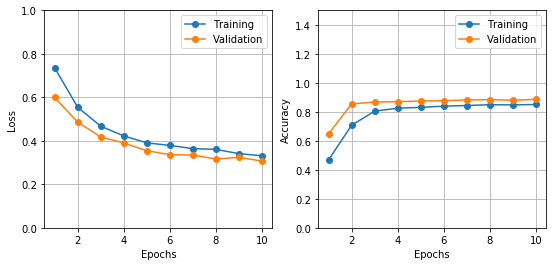

In [107]:
"""
overtraining test
"""
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(9, 4))
#fig = plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Loss")
#plt.yscale("log")
#plt.xlim(0,40)
plt.ylim(0.0,1.0)
plt.grid()
plt.legend();

plt.subplot(1, 2, 2)
#fig = plt.figure(figsize=(4, 4))
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["acc"], "o-", label="Training")
plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
#plt.yscale("log")
plt.ylim(0.0,1.5)
plt.grid()
plt.legend(loc="best");

plt.show()

In [113]:
import eli5
from eli5.sklearn import PermutationImportance
"""
to calculate variables importance, it takes time and it is not completelly 'enlightant',
do not do all the time.
"""

"\nto calculate variables importance, it takes time and it is not completelly 'enlightant',\ndo not do all the time.\n"

In [116]:
print ("Date: ", time.asctime( time.localtime(time.time()) ))
perm = PermutationImportance(k_model_binary, random_state=1).fit( # , scoring="f1_samples"
    data_odd[features].values, 
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values
)
print ("Date: ", time.asctime( time.localtime(time.time()) ))
eli5.show_weights(perm, feature_names = data_odd[features].columns.tolist(), top=len(features))

('Date: ', 'Tue Apr 16 14:04:14 2019')
('Date: ', 'Tue Apr 16 14:05:37 2019')


Weight,Feature
0.2828 ± 0.0023,gen_mHH
0.2490 ± 0.0031,diHiggsMass
0.0771 ± 0.0029,diHiggsVisMass
0.0212 ± 0.0022,mT_lep1
0.0209 ± 0.0019,met
0.0135 ± 0.0030,mT_lep2
0.0115 ± 0.0006,tau1_pt
0.0112 ± 0.0008,m_ll
0.0068 ± 0.0015,mTauTau
0.0029 ± 0.0014,tau2_pt


In [108]:
"""
Calculate the output in all dataset 
-- to pass to the training/test
"""

data_odd["NN_output"]  = k_model_binary.predict_proba(data_odd[features].values, verbose=1)[:, 1]
data_even["NN_output"] = k_model_binary.predict_proba(data_even[features].values, verbose=1)[:, 1]

 5568/34015 [===>..........................] - ETA: 0s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


34015/34015 [==============================] - 1s 28us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<Figure size 432x288 with 0 Axes>

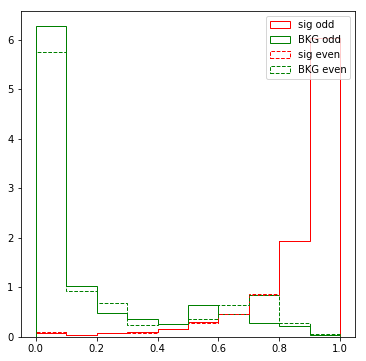

In [109]:
hist_params = {'normed': True, 'bins': 10 , 'histtype':'step'}
target = 'target'
plt.clf()

plt.figure('XGB',figsize=(6, 6))

values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 1, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 1, "weight_cx"].values,
    label="sig odd", color='r', range=(0,1), **hist_params
    )
values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 0, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 0, "weight_cx"].values,
    label="BKG odd", color='g', range=(0,1), **hist_params
    )

values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 1, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 1, "weight_cx"].values),
    label="sig even", color='r', ls='--', range=(0,1), **hist_params)
values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 0, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 0, "weight_cx"].values),
    label="BKG even", color='g', ls='--', range=(0,1), **hist_params)

#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

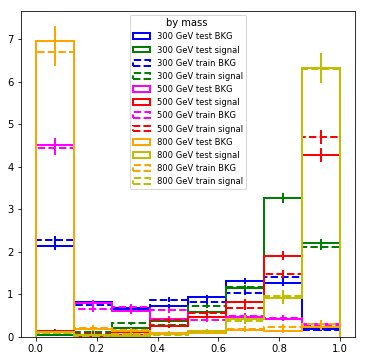

In [112]:
###############################
## classifier plot by mass
hist_params = {'normed': True, 'bins': 8 , 'histtype':'step', "lw": 2}
plt.clf()
colorcold = ['g', 'r', 'y']
colorhot = ['b', 'magenta', 'orange']

fig, ax = plt.subplots(figsize=(6, 6))
for mm, mass in enumerate(output["masses_test"]) :
    y_pred = data_even.loc[(data_even.target.values == 0) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_predS = data_even.loc[(data_even.target.values == 1) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_pred_train = data_odd.loc[(data_odd.target.values == 0) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    y_predS_train = data_odd.loc[(data_odd.target.values == 1) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    dict_plot = [
       [y_pred, "-", colorhot[mm],  str(mass)+" GeV test BKG"],
       [y_predS, "-", colorcold[mm], str(mass)+" GeV test signal"],
       [y_pred_train, "--", colorhot[mm], str(mass)+" GeV train BKG" ],
       [y_predS_train, "--", colorcold[mm],      str(mass)+" GeV train signal"]
    ]
    for item in dict_plot :
        values1, bins, _ = ax.hist(
            item[0],
            ls=item[1], color = item[2],
            label=item[3],
            range=(0,1),
            **hist_params
            )
        normed = sum(y_pred)
        mid = 0.5*(bins[1:] + bins[:-1])
        err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
        plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
#plt.xscale('log')
#plt.yscale('log')
ax.legend(loc='upper center', title="by mass ", fontsize = 'small')
#nameout = channel+'/'+bdtType+'_'+trainvar+'_'+str(len(trainVars(False)))+'_'+hyppar+'_mass_'+ str(mass)+'_XGBclassifier.pdf'

/home/acaan/.local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/acaan/.local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/acaan/.local/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/acaan/.local/lib/python2.7/site-packages/sklea

train set auc 0.9257853637883254 (mass = 300)
test set auc 0.8183902074823737 (mass = 300)
train set auc 0.8183902074823737 (mass = 300)
test set auc 0.9257853637883254 (mass = 300)
train set auc 0.9762122389720199 (mass = 500)
test set auc 0.9764211344975093 (mass = 500)
train set auc 0.9764211344975093 (mass = 500)
test set auc 0.9762122389720199 (mass = 500)
train set auc 0.9873879447144646 (mass = 800)
test set auc 0.9981463253116303 (mass = 800)
train set auc 0.9981463253116303 (mass = 800)
test set auc 0.9873879447144646 (mass = 800)


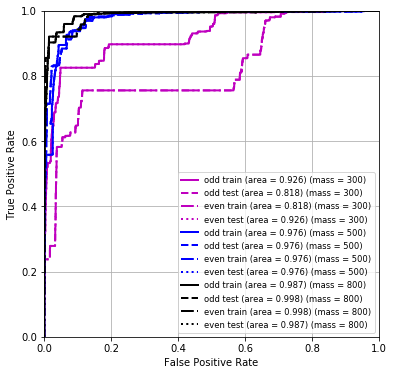

In [111]:
###############################
# by mass ROC
styleline = ['-', '--', '-.', ':']
colors_mass = ['m', 'b', 'k', 'r', 'g',  'y', 'c', ]
fig, ax = plt.subplots(figsize=(6, 6))
sl = 0


for mm, mass in enumerate(output["masses_test"]) :
    for dd, data_do in  enumerate(order_train) :
        if dd == 0 : val_data = 1
        else : val_data = 0
        fpr, tpr, thresholds = roc_curve(
            data_do.loc[(data_do["gen_mHH"] == mass), "target"].astype(np.bool),
            data_do.loc[(data_do["gen_mHH"] == mass), "NN_output"].values,
            sample_weight=(data_do.loc[(data_do["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        train_auc = auc(fpr, tpr, reorder = True)
        print("train set auc " + str(train_auc) + " (mass = " + str(mass) + ")")
        fprt, tprt, thresholds = roc_curve(
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), target].astype(np.bool), 
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"] == mass), "NN_output"].values, #proba[:,1],
            sample_weight=(order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        test_auct = auc(fprt, tprt, reorder = True)
        print("test set auc " + str(test_auct) + " (mass = " + str(mass) + ")")
        ax.plot(
            fpr, tpr,
            lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' train (area = %0.3f)'%(train_auc) + " (mass = " + str(mass) + ")"
            )
        sl += 1
        ax.plot(
            fprt, tprt,
            lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' test (area = %0.3f)'%(test_auct) + " (mass = " + str(mass) + ")"
            )
        sl += 1
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right", fontsize = 'small')
ax.grid()


In [38]:
"""
output a training and export to .pb (to be used on cpp)
"""
print ("Date: ", time.asctime( time.localtime(time.time()) ))
nameout = "model_erase"

out = k_model_binary.model.save("test_"+nameout+".hdf5")
file = open(nameout+"_variables.log","w")
file.write(str(features)+"\n")
file.close()


## This bellow does not work, easier to be done on the command line,
## in any case the bellow is a template how to run it
##!python ../test/convert_hdf5_2_pb.py --input "test_"+nameout+".hdf5" --output "test_"+nameout+".pb"

('Date: ', 'Tue Apr 16 13:33:54 2019')


In [ ]:
"""
If you want to load a model to reconpute anything or check loading just substitute k_model --> k_model_loaded
It only loads hdf5 format
"""
from keras.models import load_model
k_model_loaded = load_model("test_model_2lss_ttH_3cat_no4mom_noSemi_v6.hdf5")

In [40]:
## the next do correlation matrices with variables
import seaborn 

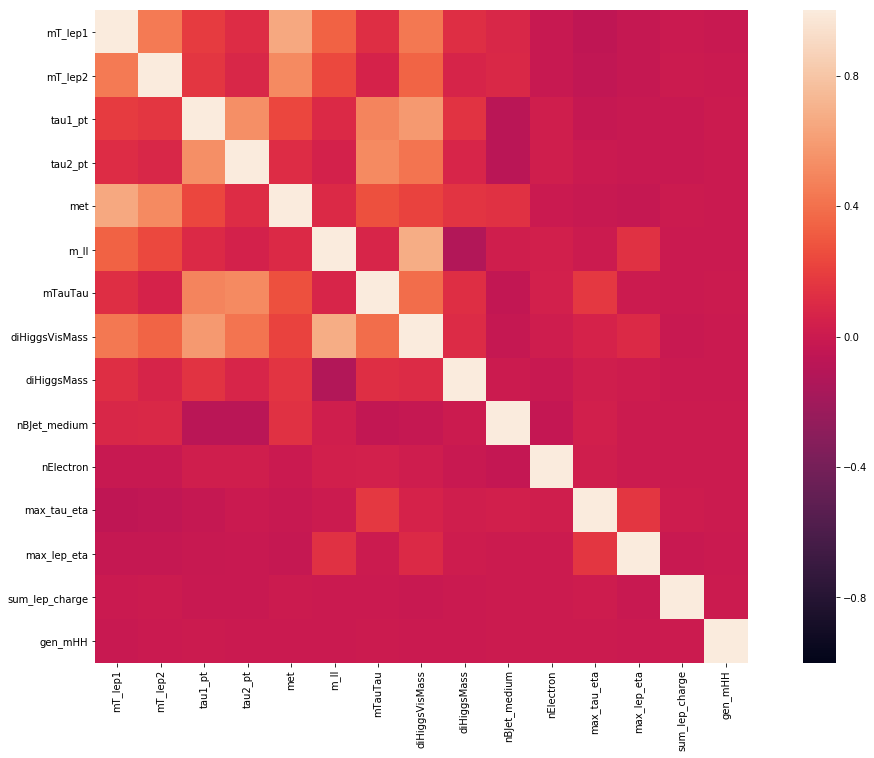

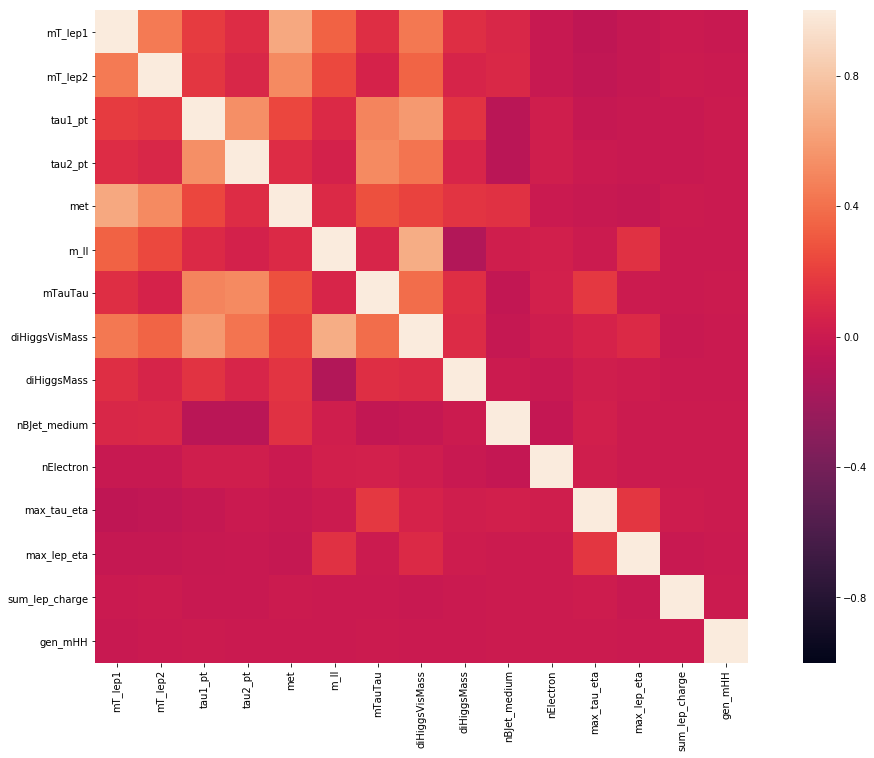

In [41]:
for target in [0,1] :
    corr_mat = data.loc[(data['target']==0), features].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.);